In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

### Reading CSV files from Dryad files

In [2]:
df_1975=pd.read_csv('C:/Users/MANPREET SINGH/Desktop/Files for Dryad/finch_beaks_1975.csv')

In [3]:
df_2012=pd.read_csv('C:/Users/MANPREET SINGH/Desktop/Files for Dryad/finch_beaks_2012.csv')

### Having a better look at the data

In [4]:
df_1975.head()

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [5]:
df_1975.isnull().sum()

band               0
species            0
Beak length, mm    0
Beak depth, mm     0
dtype: int64

In [6]:
df_2012.head()

,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9
2,19032,fortis,9.3,7.5
3,19041,fortis,10.3,9.6
4,19044,fortis,11.0,9.2


In [7]:
df_2012.isnull().sum()

band       0
species    0
blength    0
bdepth     0
dtype: int64

### Filtering and combining the data for comparison purpose

In [8]:
df_1975 = pd.DataFrame(df_1975)
df_2012 = pd.DataFrame(df_2012)

gb_1975 = df_1975.groupby(df_1975['species'])
df_filtered_1975 = gb_1975.get_group('scandens').reset_index(drop=True)

gb_2012 = df_2012.groupby(df_2012['species'])
df_filtered_2012 = gb_2012.get_group('scandens').reset_index(drop=True)

df_combine=pd.concat([df_filtered_1975['Beak depth, mm'],df_filtered_2012['bdepth']],axis=1).reset_index(drop=True)
df_combine.rename(columns={'Beak depth, mm' : '1975','bdepth' : '2012'},inplace=True)


### Swarmplot to compare the Beak depth in the year 1975 and 2012

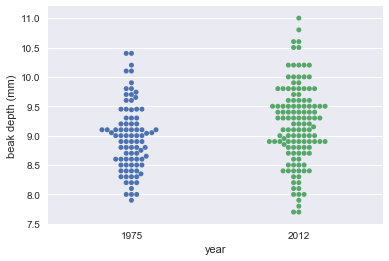

In [9]:
sns.set()
_=sns.swarmplot(data=df_combine)
_=plt.xlabel('year')
_=plt.ylabel('beak depth (mm)')

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

In [10]:

def ecdf(x_data) : #done
    x = np.sort(x_data)
    y = np.arange(1,len(x)+1) / len(x)

    return x,y


def bootstrap_replicate_1d(data,func) : #done
    return func(np.random.choice(data,size=len(data)))

def draw_bs_reps(data, func, size=1):  #done
    """Draw bootstrap replicates."""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates


def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return bs_slope_reps, bs_intercept_reps
    



### Calculating and plotting ECDF(Empirical distribution function)

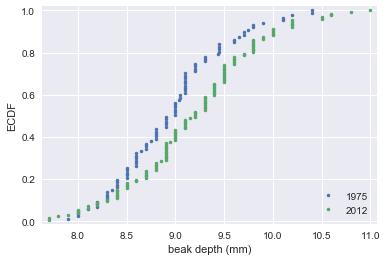

In [11]:
#The depth of scandens beak
bd_1975=df_filtered_1975['Beak depth, mm']
bd_2012=df_filtered_2012['bdepth']

#The lengths of scandens beak
bl_1975=df_filtered_1975['Beak length, mm']
bl_2012=df_filtered_2012['blength']



# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.

### Parameter estimation of beak depth

In [12]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012)-np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975,np.mean,10000)
bs_replicates_2012 = draw_bs_reps(bd_2012,np.mean,10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates =  bs_replicates_2012 - bs_replicates_1975 

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.2262204724409429 mm
95% confidence interval = [0.06125272 0.39289619] mm


### Hypothesis test: Are beaks deeper in 2012?

In [13]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted,np.mean,10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted,np.mean,10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)


p = 0.004


We get a p-value of 0.0032, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

### EDA of beak length and depth

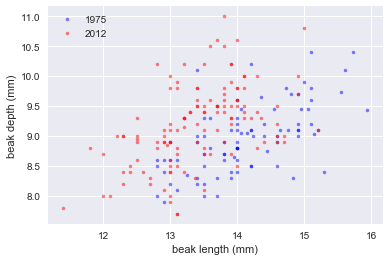

In [14]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

### Linear Regression

In [15]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975,bd_1975,1)
slope_2012, intercept_2012 = np.polyfit(bl_2012,bd_2012,1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(bl_1975,bd_1975,1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(bl_2012,bd_2012,1000)
        
# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975,[2.5,97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012,[2.5,97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975,[2.5,97.5])

intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012,[2.5,97.5])



# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.32579056 0.58963719]
1975: intercept = 2.3908752365842263 conf int = [0.65237703 4.37107944]
2012: slope = 0.462630358835313 conf int = [0.33404723 0.59444333]
2012: intercept = 2.9772474982360198 conf int = [1.20877393 4.74164595]


It looks like they have the same slope, but different intercepts.

### Displaying the linear regression results

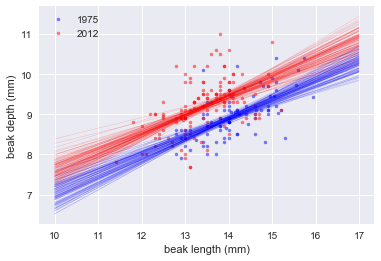

In [16]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x,( bs_slope_reps_1975[i]*x + bs_intercept_reps_1975[i]),
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, (bs_slope_reps_2012[i]*x + bs_intercept_reps_2012[i]),
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

### Beak length to depth ratio

In [17]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean,10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean,10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975,[0.5,99.5])
conf_int_2012 = np.percentile(bs_replicates_2012,[0.5,99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)


1975: mean ratio = 1.5788823771858533 conf int = [1.55672213 1.60128649]
2012: mean ratio = 1.4658342276847778 conf int = [1.44421785 1.48782406]


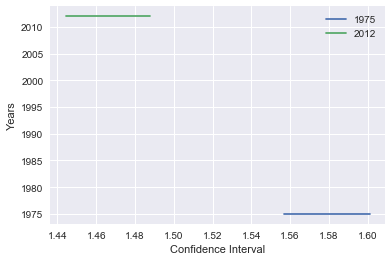

In [18]:
_=plt.plot(conf_int_1975,[1975,1975])

_=plt.plot(conf_int_2012,[2012,2012])


_ = plt.xlabel('Confidence Interval')
_ = plt.ylabel('Years')
_ = plt.legend(('1975', '2012'), loc='upper right')

plt.show()

The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.